# Project Overview

This project analyzes customer behavior patterns using a dataset of e-commerce transactions. The goal is to extract insights on spending habits, churn factors, and customer segmentation to inform business decisions.

## Tech Stack

Python: Data processing and analysis

Pandas: Data manipulation

Matplotlib & Seaborn: Data visualization

Scikit-Learn: Clustering analysis

In [34]:
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns  
import numpy as np 
import matplotlib.ticker as mticker
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [35]:
df = pd.read_csv("/kaggle/input/e-commerce-customer-for-behavior-analysis/ecommerce_customer_data_custom_ratios.csv")

# Dataset Overview

The dataset consists of 250,000 rows and 13 columns, including:

Customer ID: Unique identifier for each customer

Purchase Date: Timestamp of transaction

Product Category: Category of the purchased item

Product Price: Price of the purchased product

Quantity: Number of units bought

Total Purchase Amount: Total spending by customer

Payment Method: Mode of transaction (Credit Card, PayPal, etc.)

Customer Age, Gender: Demographic information

Returns: Whether they retruned their purchase

Churn: Whether the customer stopped purchasing (1: churned, 0: active)

In [36]:
df.head

<bound method NDFrame.head of         Customer ID        Purchase Date Product Category  Product Price  \
0             46251  2020-09-08 09:38:32      Electronics             12   
1             46251  2022-03-05 12:56:35             Home            468   
2             46251  2022-05-23 18:18:01             Home            288   
3             46251  2020-11-12 13:13:29         Clothing            196   
4             13593  2020-11-27 17:55:11             Home            449   
...             ...                  ...              ...            ...   
249995        33308  2023-08-10 13:39:06         Clothing            279   
249996        48835  2021-11-23 01:30:42             Home             27   
249997        21019  2020-07-02 14:04:48             Home             17   
249998        49234  2020-12-30 02:02:40            Books            398   
249999        16971  2021-03-13 16:28:35      Electronics            425   

        Quantity  Total Purchase Amount Payment Method  C

# Data Preprocessing

* Handling Missing Values:

Checked for missing values and imputed or removed them where necessary.

* Feature Engineering:

Created "Spending Category" based on total purchase amount (High, Medium, Low).

Extracted "Year-Month" from purchase date.

Assigned customers to clusters based on spending patterns.

* Merging Data:

Merged spending category and clustering labels into the main dataframe.

In [37]:
print(df.isnull().sum())

Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47596
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64


Handling Missing Values in Returns Column:

The **"Returns"** column had **47,596 missing values**. Instead of removing these rows, we assumed:  

- Missing values indicate **no return (0)**  
- This assumption simplifies analysis, as we are not focusing on returns  
- If needed, return behavior can be explored separately  



In [38]:
df['Returns'] = df['Returns'].fillna(0)
print(df.dtypes)

Customer ID                int64
Purchase Date             object
Product Category          object
Product Price              int64
Quantity                   int64
Total Purchase Amount      int64
Payment Method            object
Customer Age               int64
Returns                  float64
Customer Name             object
Age                        int64
Gender                    object
Churn                      int64
dtype: object


In [39]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [40]:
df.describe()

df.nunique()

Customer ID               49673
Purchase Date            249736
Product Category              4
Product Price               491
Quantity                      5
Total Purchase Amount      5247
Payment Method                4
Customer Age                 53
Returns                       2
Customer Name             39920
Age                          53
Gender                        2
Churn                         2
dtype: int64

# Purchasing trends over time (2020-summer 2023)

In [41]:
print(df['Purchase Date'].min(), df['Purchase Date'].max())

2020-01-01 00:15:00 2023-09-15 12:24:08


Note: Exclusion of September 2023
September 2023 will be excluded from the analysis because the dataset only contains transactions up to September 15. Including it would misrepresent the overall purchasing trends.

In [42]:
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])
df['Year-Month'] = df['Purchase Date'].dt.to_period('M')
monthly_sales = df.groupby('Year-Month')['Total Purchase Amount'].sum().reset_index()

In [43]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

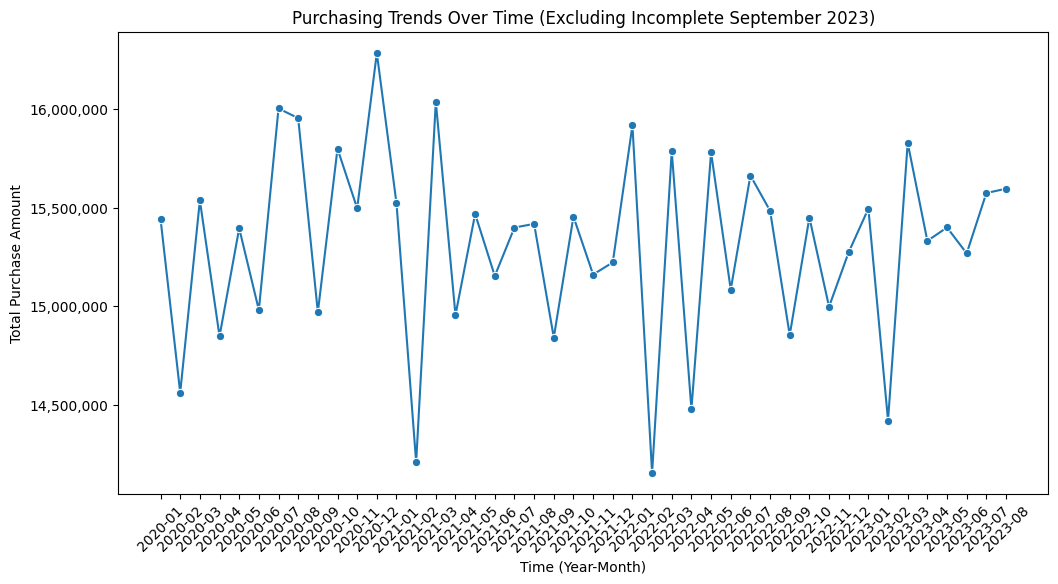

In [44]:
df_filtered = df[df['Year-Month'] < '2023-09']
monthly_sales_filtered = df_filtered.groupby('Year-Month')['Total Purchase Amount'].sum().reset_index()

plt.figure(figsize=(12, 6))
ax = sns.lineplot(x=monthly_sales_filtered['Year-Month'].astype(str), 
                  y=monthly_sales_filtered['Total Purchase Amount'], 
                  marker='o')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.xticks(rotation=45)
plt.xlabel("Time (Year-Month)")
plt.ylabel("Total Purchase Amount")
plt.title("Purchasing Trends Over Time (Excluding Incomplete September 2023)")
plt.show()

# Seasonability analysis for the last 12 months

In [45]:
latest_full_year = df['Purchase Date'].dt.year.max() - (df['Purchase Date'].dt.month < 9).any()
df_one_year = df[df['Purchase Date'].dt.year == latest_full_year].copy()

In [46]:
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

In [47]:
df_one_year.loc[:, 'Season'] = df_one_year['Purchase Date'].dt.month.apply(get_season)

In [48]:
seasonal_sales = df_one_year.groupby('Season')['Total Purchase Amount'].sum().reset_index()

In [49]:
season_order = ["Winter", "Spring", "Summer", "Fall"]
seasonal_sales['Season'] = pd.Categorical(seasonal_sales['Season'], categories=season_order, ordered=True)

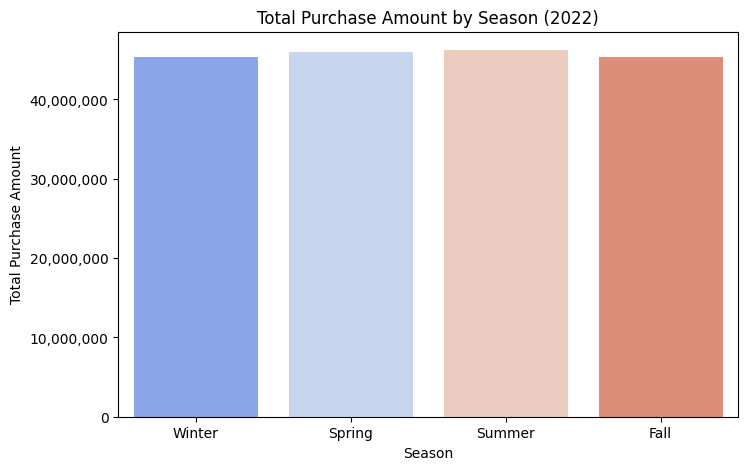

In [50]:
plt.figure(figsize=(8, 5))
sns.barplot(data=seasonal_sales, x='Season', y='Total Purchase Amount', palette="coolwarm")

plt.title(f"Total Purchase Amount by Season ({latest_full_year})")
plt.xlabel("Season")
plt.ylabel("Total Purchase Amount")

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()

# Distribution of Product Prices

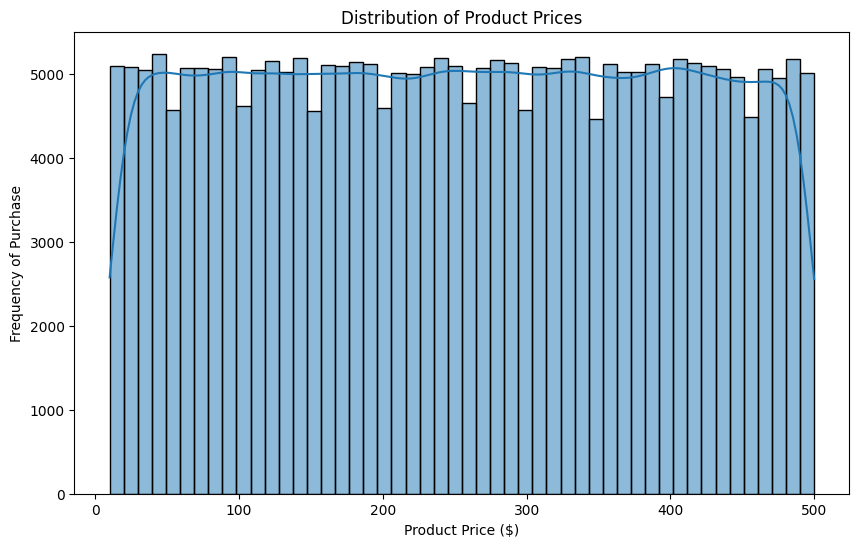

In [69]:
plt.figure(figsize=(10, 6))
sns.histplot(df["Product Price"], bins=50, kde=True)
plt.xlabel("Product Price ($)")
plt.ylabel("Frequency of Purchase")
plt.title("Distribution of Product Prices")
plt.show()

# Churn Rate Analysis

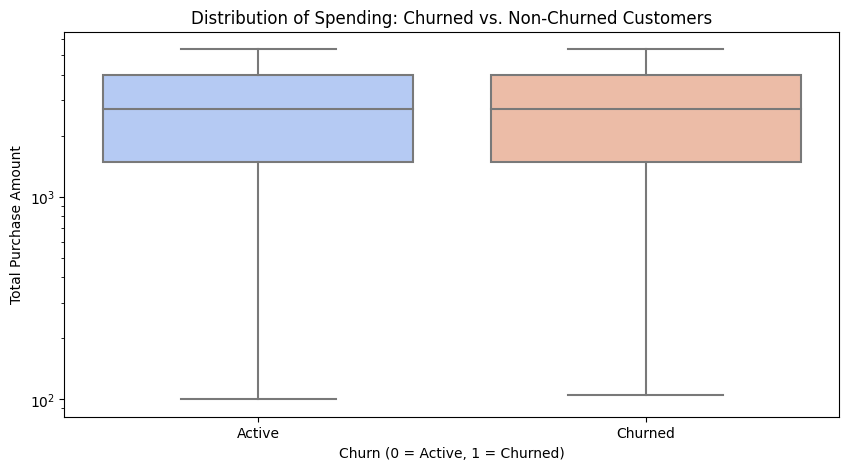

In [71]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Churn'], y=df['Total Purchase Amount'], palette="coolwarm")
plt.title("Distribution of Spending: Churned vs. Non-Churned Customers")
plt.xlabel("Churn (0 = Active, 1 = Churned)")
plt.ylabel("Total Purchase Amount")
plt.xticks([0, 1], ["Active", "Churned"])
plt.yscale("log")  # Log scale to show outliers better
plt.show()

In [76]:
df = df.merge(customer_spending[["Customer ID", "Spending Category"]], on="Customer ID", how="left")

print(df["Spending Category"].isna().sum(), "missing Spending Category values")
print(df.head())

0 missing Spending Category values
   Customer ID       Purchase Date Product Category  Product Price  Quantity  \
0        46251 2020-09-08 09:38:32      Electronics             12         3   
1        46251 2022-03-05 12:56:35             Home            468         4   
2        46251 2022-05-23 18:18:01             Home            288         2   
3        46251 2020-11-12 13:13:29         Clothing            196         1   
4        13593 2020-11-27 17:55:11             Home            449         1   

   Total Purchase Amount Payment Method  Customer Age  Returns  \
0                    740    Credit Card            37      0.0   
1                   2739         PayPal            37      0.0   
2                   3196         PayPal            37      0.0   
3                   3509         PayPal            37      0.0   
4                   3452    Credit Card            49      0.0   

         Customer Name  Age  Gender  Churn Year-Month  Cluster  \
0  Christine Hernande

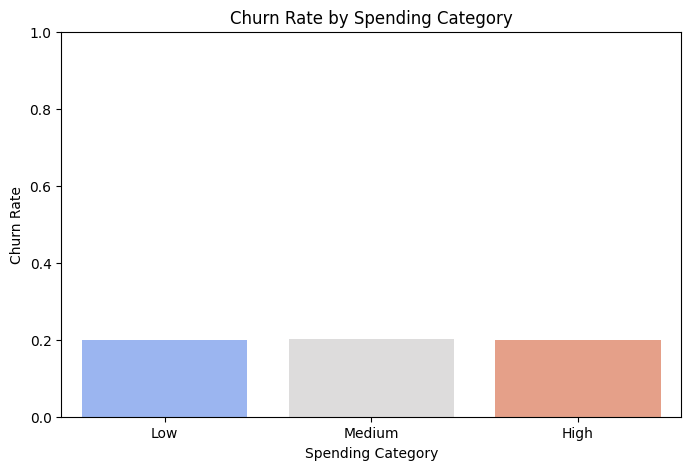

In [77]:
df = df.drop(columns=["Spending Category_x", "Spending Category_y"], errors="ignore")

if "Spending Category" in df.columns:
    spending_churn = df.groupby("Spending Category")["Churn"].mean()

    # Plot churn rate by spending category
    plt.figure(figsize=(8, 5))
    sns.barplot(x=spending_churn.index, y=spending_churn.values, palette="coolwarm")
    plt.title("Churn Rate by Spending Category")
    plt.xlabel("Spending Category")
    plt.ylabel("Churn Rate")
    plt.ylim(0, 1)  # Churn is a proportion (0 to 1)
    plt.show()
else:
    print("Error: 'Spending Category' is missing after merge")

In [78]:
print(df["Spending Category"].value_counts())


Spending Category
High      121390
Medium     79907
Low        48703
Name: count, dtype: int64


In [79]:
print(df.groupby("Spending Category")["Churn"].mean())


Spending Category
Low       0.198776
Medium    0.200708
High      0.198987
Name: Churn, dtype: float64


* Customers were categorized into High, Medium, and Low spenders.

* Average churn rate across all categories was ~20%, with no significant difference between groups.

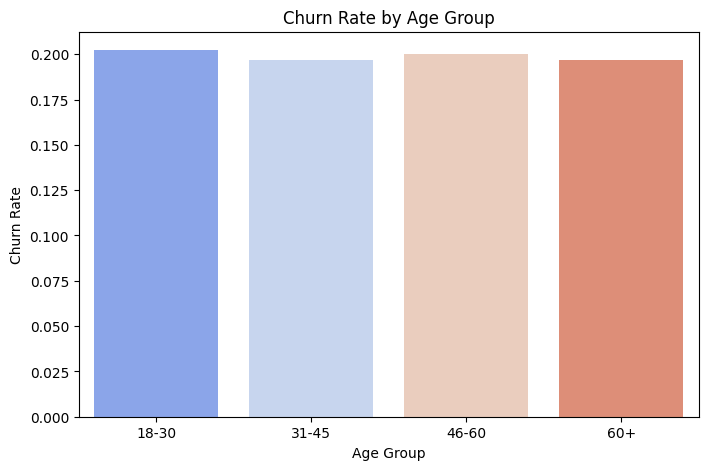

In [80]:
df["Age Group"] = pd.cut(df["Customer Age"], bins=[18, 30, 45, 60, 100], 
                         labels=["18-30", "31-45", "46-60", "60+"])

age_churn = df.groupby("Age Group")["Churn"].mean()
plt.figure(figsize=(8, 5))
sns.barplot(x=age_churn.index, y=age_churn.values, palette="coolwarm")
plt.title("Churn Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Churn Rate")
plt.show()

* A slight variation in churn was observed across different age groups.

* Gender distribution had no major impact on churn behavior.

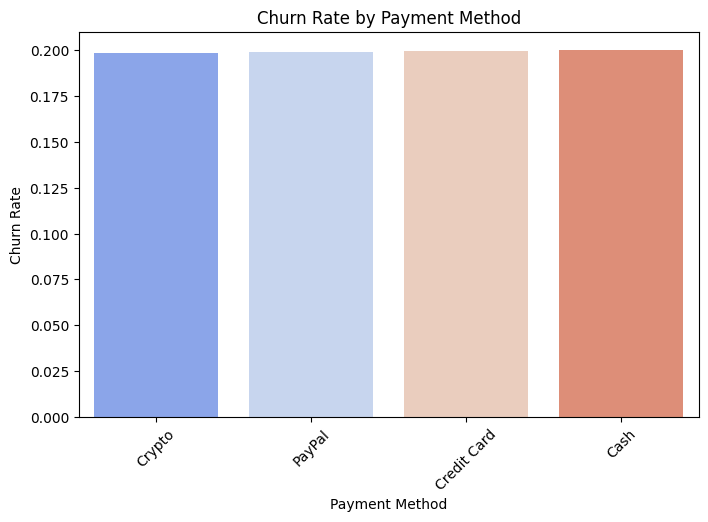

In [82]:
payment_churn = df.groupby("Payment Method")["Churn"].mean().sort_values()
plt.figure(figsize=(8, 5))
sns.barplot(x=payment_churn.index, y=payment_churn.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Churn Rate by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Churn Rate")
plt.show()

Payment method did not strongly correlate with churn.

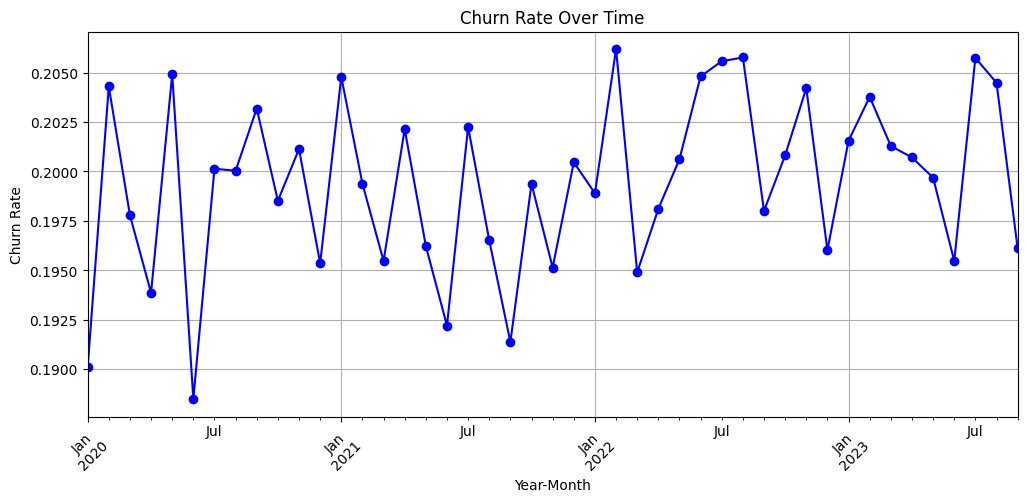

In [83]:
df["Year-Month"] = pd.to_datetime(df["Purchase Date"]).dt.to_period("M")

time_churn = df.groupby("Year-Month")["Churn"].mean()
plt.figure(figsize=(12, 5))
time_churn.plot(marker="o", linestyle="-", color="b")
plt.title("Churn Rate Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Churn Rate")
plt.xticks(rotation=45)
plt.grid()
plt.show()

Churn rates kept changing slightly with time 

# Preferred payment method analysis

In [ ]:
payment_distribution = df.groupby('Payment Method')['Total Purchase Amount'].sum()

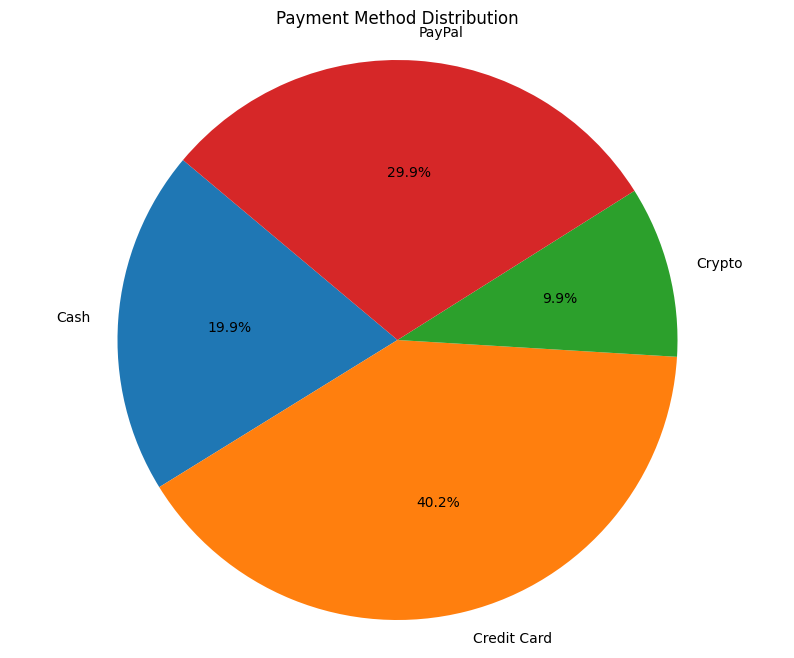

In [90]:
plt.figure(figsize=(10, 8))
plt.pie(payment_distribution, labels=payment_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Payment Method Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

Credit cards and Paypal were preferred over cash and crypto.

# Purchase quantity vs Return analysis 

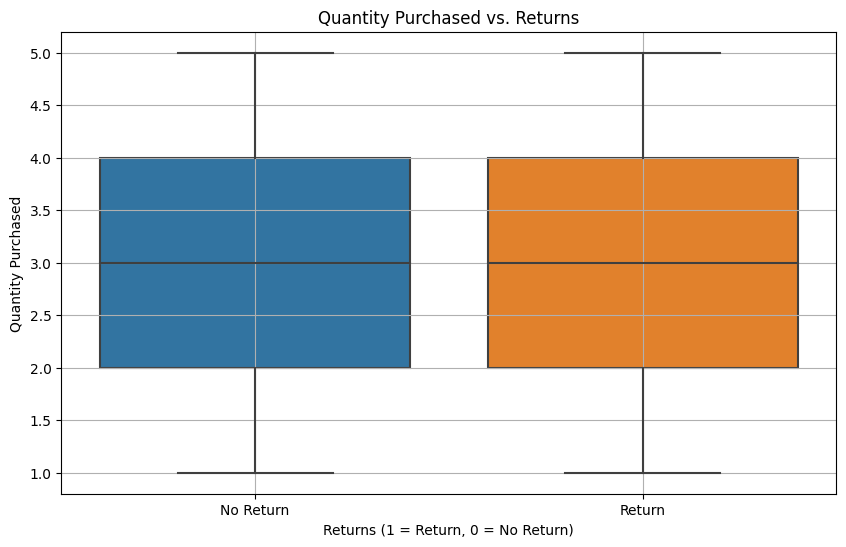

In [88]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Returns', y='Quantity', data=df)
plt.title('Quantity Purchased vs. Returns')
plt.xlabel('Returns (1 = Return, 0 = No Return)')
plt.ylabel('Quantity Purchased')
plt.xticks([0, 1], ['No Return', 'Return'])
plt.grid(True)
plt.show()

Quantity of products bought showed no trend to determine if they were returned.

# Product category most returned

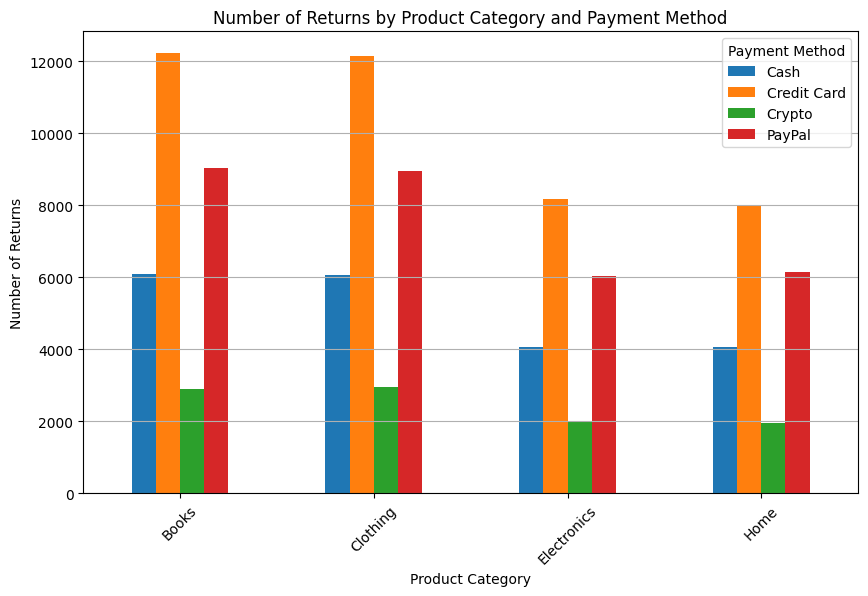

In [89]:
returns_count = df.groupby(['Product Category', 'Payment Method'])['Returns'].sum().unstack(fill_value=0)
returns_count.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Returns by Product Category and Payment Method')
plt.xlabel('Product Category')
plt.ylabel('Number of Returns')
plt.xticks(rotation=45)
plt.legend(title='Payment Method')
plt.grid(axis='y')
plt.show()

* Books and clothing were most returned

* Credit cards were used the most to buy and the payment method distribution for returns remained the same.

# Customer segmentation (Clustering based on demographics)

In [53]:
features = ['Total Purchase Amount', 'Quantity', 'Customer Age']
df_cluster = df[features].copy()
df_cluster = df_cluster.dropna()

In [54]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels, sample_size=5000, random_state=42)
    silhouette_scores.append(score)

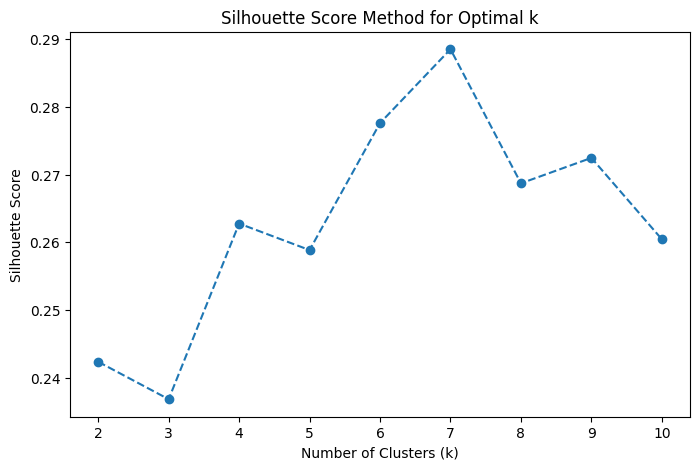

Best k based on silhouette score: 7


In [55]:
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Method for Optimal k")
plt.show()

best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Best k based on silhouette score: {best_k}")


In [56]:
kmeans = MiniBatchKMeans(n_clusters=7, random_state=42, batch_size=1000, n_init=10)
df_cluster['Cluster'] = kmeans.fit_predict(df_scaled)

In [57]:
cluster_summary = df_cluster.groupby('Cluster').mean()
print(cluster_summary)

         Total Purchase Amount  Quantity  Customer Age
Cluster                                               
0                  1245.210356  2.629072     27.999793
1                  3994.787340  3.962290     57.721769
2                  3519.721182  4.549491     30.189290
3                  3973.395029  1.460190     57.103635
4                  1464.544759  1.952538     55.038967
5                  1417.802784  4.560286     51.233478
6                  3787.337396  1.957933     30.460176


 📊 Customer Segmentation Analysis (k=7)

🔹 Key Observations  
| Cluster | Avg Purchase ($) | Avg Quantity | Avg Age | Possible Customer Type |
|---------|-----------------|--------------|---------|------------------------|
| **0**   | **1245**        | 2.6          | 28      | **Young low spenders** |
| **1**   | **3994**        | 3.96         | 57.7    | **Older high spenders** |
| **2**   | **3519**        | 4.55         | 30.2    | **Young bulk buyers** |
| **3**   | **3973**        | 1.46         | 57.1    | **Older minimal buyers** |
| **4**   | **1464**        | 1.95         | 55.0    | **Older low spenders** |
| **5**   | **1417**        | 4.56         | 51.2    | **Middle-aged bulk buyers** |
| **6**   | **3787**        | 1.95         | 30.5    | **Young high spenders** |

---

🔹 Business Insights  
- **Younger customers** tend to either be low spenders or bulk buyers.  
- **Older customers** are split between **high spenders** and **minimal buyers**.  
- **Middle-aged buyers** tend to buy in bulk but don’t spend excessively.  
- **Marketing Implications**:  
  - Focus promotional campaigns on **bulk buyers**.  
  - Upsell to **older high spenders** with premium products.  
  - Convert **young low spenders** into repeat customers through discounts or loyalty programs.  

---

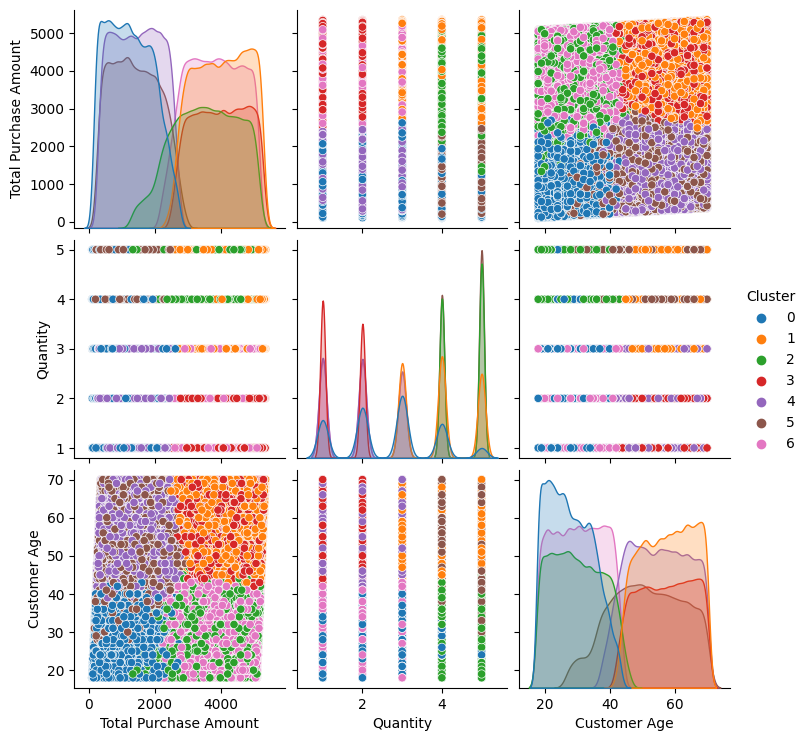

In [58]:
sns.pairplot(df_cluster, hue='Cluster', palette='tab10', diag_kind='kde')
plt.show()


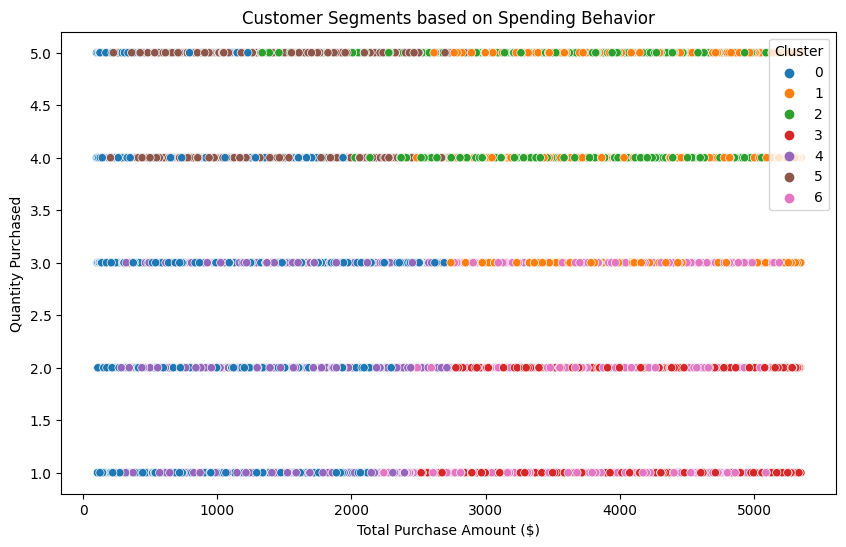

In [59]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_cluster['Total Purchase Amount'], 
                y=df_cluster['Quantity'], 
                hue=df_cluster['Cluster'], 
                palette='tab10')
plt.xlabel("Total Purchase Amount ($)")
plt.ylabel("Quantity Purchased")
plt.title("Customer Segments based on Spending Behavior")
plt.legend(title="Cluster", loc="upper right")
plt.show()

In [60]:
df['Cluster'] = kmeans.labels_

In [61]:
gender_counts = df.groupby('Cluster')['Gender'].value_counts(normalize=True).unstack()
gender_counts.columns = ['Female Proportion', 'Male Proportion']
print(gender_counts)

         Female Proportion  Male Proportion
Cluster                                    
0                 0.500117         0.499883
1                 0.505715         0.494285
2                 0.497192         0.502808
3                 0.500494         0.499506
4                 0.506067         0.493933
5                 0.500962         0.499038
6                 0.503358         0.496642


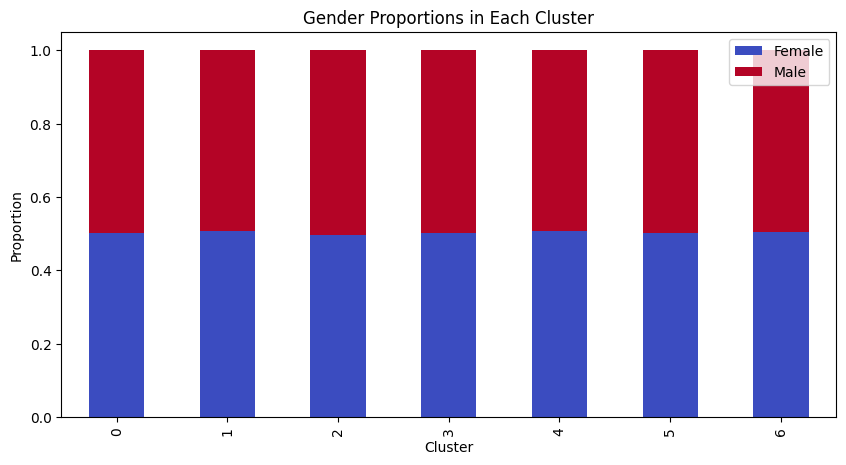

In [62]:
gender_counts.plot(kind='bar', stacked=True, figsize=(10, 5), colormap='coolwarm')
plt.title("Gender Proportions in Each Cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.legend(["Female", "Male"])
plt.show()

* A stacked bar chart shows that gender distribution is almost identical across clusters.
* No single cluster is significantly male- or female-dominated.
* This suggests that gender is not a key factor in driving spending behavior in this dataset.


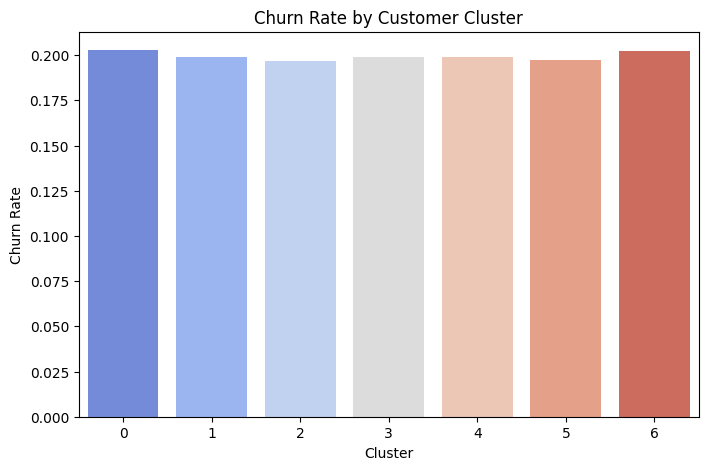

In [84]:
cluster_churn = df.groupby("Cluster")["Churn"].mean().sort_values()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_churn.index, y=cluster_churn.values, palette="coolwarm")
plt.title("Churn Rate by Customer Cluster")
plt.xlabel("Cluster")
plt.ylabel("Churn Rate")
plt.show()

However, churn rate remained consistent (~20%) across all clusters.

In [85]:
df["Cluster"].value_counts()

Cluster
4    40137
6    39461
1    39194
0    38587
5    33258
2    32046
3    27317
Name: count, dtype: int64

In [87]:
df_numeric = df.select_dtypes(include=["number"])
df_numeric.corr()["Churn"].sort_values()

Customer Age            -0.006015
Age                     -0.006015
Customer ID             -0.005398
Quantity                -0.002674
Product Price           -0.001666
Cluster                 -0.000600
Total Purchase Amount    0.000770
Returns                  0.001387
Churn                    1.000000
Name: Churn, dtype: float64

* Checked correlation between churn and numerical variables.

* No strong correlation found (all values ~0.00 to -0.006).

* Features like Total Purchase Amount, Returns, Age, and Cluster had minimal impact on churn.

# Key Insights from Customer Behavior Analysis
*  Payment Method Preferences

Credit cards and PayPal are the most preferred payment methods, indicating that marketing campaigns and promotions should optimize for these payment options.

* Gender-Neutral Targeting

Both male and female customers exhibit similar purchasing behaviors, suggesting that marketing efforts should remain gender-inclusive rather than skewed toward a particular demographic.

* Consistent Seasonal Demand

Customer spending patterns remain stable across different seasons, implying that promotions and product launches should be maintained year-round rather than focusing on specific peak seasons.

* Cluster-Based Targeting Strategy

The seven identified customer clusters reveal distinct spending habits and age demographics. Personalized marketing strategies should be developed for each segment to maximize engagement and conversions.